# Insight into AirBNB Boston Data

A quick glance at [AirBnB Boston data](https://www.kaggle.com/airbnb/boston) arouse curiosity to see if following questions can be convincingly answered using data analysis.

- What are hot locations?
- What are peak seasons?
- Does number of properties in neighbourhood affect the occupancy?
- What are the factors affecting overall occupancy and review ratings?


Load the necessary libraries and list the files in dataset

In [63]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))

['listings.csv', 'calendar.csv', 'reviews.csv']


## Data Understanding

### Listings
Take a look at the data set describing all the different properties that are being offered at airBNB in Boston.

In [64]:
df_listings = pd.read_csv('../input/listings.csv', parse_dates=['host_since'])
print(df_listings.shape)
df_listings.head(n=5)

(3585, 95)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,...,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,NaN,26,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,moderate,f,f,1

Take a look at missing values in dataset.

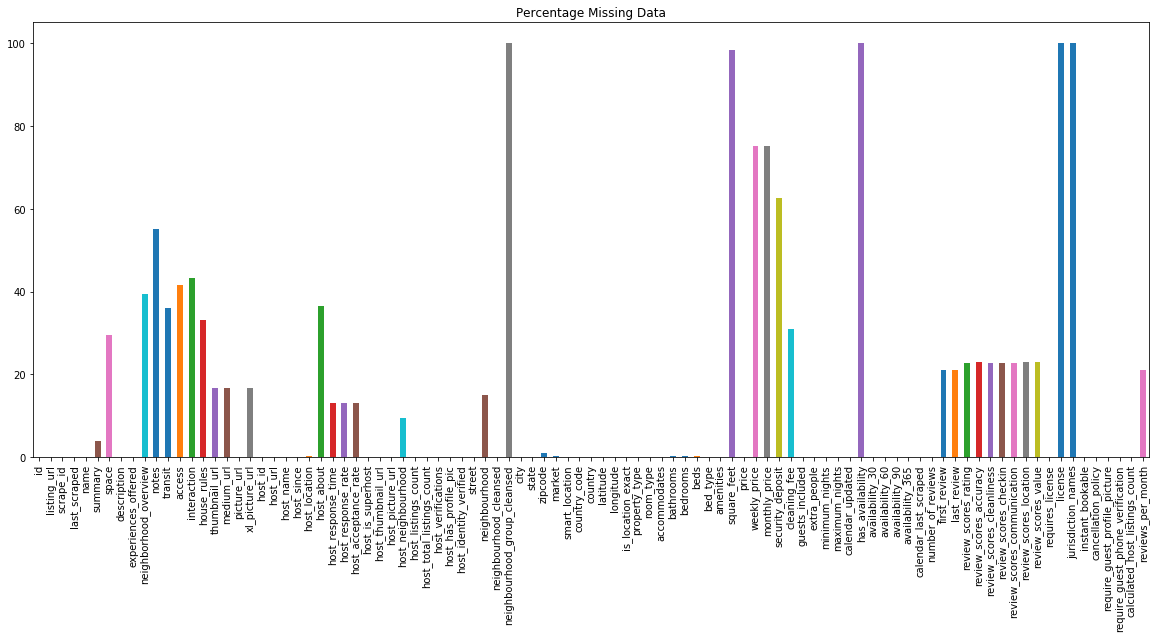

In [65]:
(100*(df_listings.shape[0] - df_listings.count())/df_listings.shape[0]).plot(kind="bar", title="Percentage Missing Data", figsize=(20, 8));

**Following columns have high percentage of missing data**
- neighbourhood_group_cleansed
- square_feet
- has_availability
- license
- jurisdiction_names

### Calendar/Occupancy Data

Load and understand structure of calendar/occupancy data

In [66]:
df_calendar = pd.read_csv('../input/calendar.csv')
print(df_calendar.shape)
df_calendar.head()

(1308890, 4)


,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


- available is a boolean column with string values 'f' and 't' representing occupied and available status
- price values are available only for dates when property is available and missing when property is occupied


### Customer Reviews Data

Glance into the customer reviews to understand the data

In [67]:
df_reviews = pd.read_csv('../input/reviews.csv')
print(df_reviews.shape)
df_reviews.head()

(68275, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


## Data Preparation

### Define some utility functions

In [68]:
def amt_str_to_float(text):
    '''
    INPUT:
    text - formatted amount text to convert to float value
    OUTPUT:
    amount - A parsed float value
    
    Parses the amount values specified as "$2,332" into a float value 2332.00
    '''
    return float(text[1:].replace(',','')) if type(text) == str else text

def pct_str_to_float(text):
    '''
    INPUT:
    text - formatted percentage text to convert to float value
    OUTPUT:
    percentage - A parsed float value
    
    Parses the text percentage values specified as "98%" into a float value 98.00
    '''
    return float(text[:-1]) if type(text) == str else text

analyser = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    '''
    INPUT:
    text - input text for sentiment analysis
    OUTPUT:
    score - sentiment score asa float value
    
    Calculates the sentiment score using VADER-Sentiment library and returns compound score
    '''
    return analyser.polarity_scores(text)['compound']

### Cleanup and Prepare Listings Data

- Of various features describing the property we use *description* to calculate the sentiment score and store it as *description_score*. This is done to see if property description has any effect on occupancy and review ratings.
- Drop irrelevant columns 
- Apply other data wrangling and imputation techniques to fill the missing values.

In [69]:
def prepare_listings_data(df):
    dfc = df.copy()
    
    # 1. Defined calculated/derived columns
    # Extract sentiment score of the property description
    dfc['description_score'] = dfc.description.apply(get_sentiment_score)

    # Extract annnual proportional occupancy for the  property
    dfc['occupancy'] = (1 - dfc.availability_365/365)
    
    # Extract age of property listing
    dfc['listing_age'] = (datetime.datetime(2017, 1, 1) - dfc.host_since).apply(lambda col: col.days)
    
    # 2. Drop irrelevant columns
    columns_having_same_values = ['country', 'country_code', 'state', 'experiences_offered']


    # Drop Columns that are 
    # a. descriptive, 
    # b. image urls
    # c. High NaN values
    # d. that have been mapped to other calculated/provided columns
    #  - e.g. coarse 'neighbourhoood' is considered in analysis instead of geo locations, street etc.
    #  - description is mapped to corresponding sentiment score and availability_365 is mapped to occupancy
    irrelevant_columns = ['listing_url', 'scrape_id', 'last_scraped', 'notes', 'transit', 
                          'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 
                          'picture_url', 'xl_picture_url', 'host_url', 'host_name',
                          'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications',
                          'calculated_host_listings_count', 'reviews_per_month', 'requires_license', 'license', 'jurisdiction_names',
                          'host_id', 'host_location', 'host_about', 'neighbourhood_group_cleansed', 'latitude', 'longitude',
                           'market', 'smart_location', 'street', 'square_feet', 'amenities',
                          'maximum_nights', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90',
                          'calendar_last_scraped', 'first_review', 'last_review', 'neighbourhood', 'neighborhood_overview',
                          'name' ,'summary' ,'space' ,'description', 'city', 'zipcode', 'availability_365', 'host_since'                  
                         ]

    columns_to_drop = columns_having_same_values
    columns_to_drop.extend(irrelevant_columns)
    
    dfc.drop(columns_to_drop, axis=1, inplace=True)

    # 3. Convert binary columns into 0,1
    binary_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
                      'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification'
                     ]
    for col in binary_columns:
        dfc[col] = dfc[col].apply(lambda c: 1 if c == 't' else 0)

    # 4. Prepare numeric columns
    # Convert Amount columns to number from string
    dfc['price'] = dfc['price'].apply(amt_str_to_float)
    dfc['weekly_price'] = dfc['weekly_price'].apply(amt_str_to_float)
    dfc['monthly_price'] = dfc['monthly_price'].apply(amt_str_to_float)
    dfc['security_deposit'] = dfc['security_deposit'].apply(amt_str_to_float)
    dfc['cleaning_fee'] = dfc['cleaning_fee'].apply(amt_str_to_float)
    dfc['extra_people'] = dfc['extra_people'].apply(amt_str_to_float)

    # Convert String Percentage values to numeric
    dfc['host_response_rate'] = dfc['host_response_rate'].apply(pct_str_to_float)
    dfc['host_acceptance_rate'] = dfc['host_acceptance_rate'].apply(pct_str_to_float)


    # 5. Apply Imputation to fill missing values

    # security deposit and cleaning fee can be marked 0 if not specified
    dfc['security_deposit'].fillna(0, inplace=True)
    dfc['cleaning_fee'].fillna(0, inplace=True)

    # Weekly and Monthly prices can be filled with simply multiplication.
    dfc['weekly_price'] = np.where(np.isnan(dfc['weekly_price']), dfc['price']*7,  dfc['weekly_price'])
    dfc['monthly_price'] = np.where(np.isnan(dfc['monthly_price']), dfc['price']*30,  dfc['monthly_price'])

    # Missing Number of Bathrooms: We can assume 1 bathroom per bedroom (if bedrooms are specified)
    # Vice-versa Missing Number of Bedrooms: We can assume to be same as number of bathrooms (if specified)
    dfc['bathrooms'] = np.where(np.isnan(dfc['bathrooms']), dfc['bedrooms'],  dfc['bathrooms'])
    dfc['bedrooms'] = np.where(np.isnan(dfc['bedrooms']), dfc['bathrooms'],  dfc['bedrooms'])

    # Missing number of beds - Fill with average number of beds per bedroom * number_of_bedrooms
    average_beds_ped_bedroom = (dfc[dfc.bedrooms>0].beds/dfc[dfc.bedrooms>0].bedrooms).mean()
    dfc['beds'] = np.where(np.isnan(dfc['beds']), average_beds_ped_bedroom*dfc['bedrooms'],  dfc['beds'])


    # Fill host_response_rate and host_acceptance_rate to corresponding mean values
    dfc['host_response_rate'].fillna(dfc['host_response_rate'].mean(), inplace=True)
    dfc['host_acceptance_rate'].fillna(dfc['host_acceptance_rate'].mean(), inplace=True)

    # Fill Categorical variables using mode()
    dfc['host_response_time'].fillna(dfc['host_response_time'].mode()[0], inplace=True)
    dfc['property_type'].fillna(dfc['property_type'].mode()[0], inplace=True)
    
    dfc.rename({'neighbourhood_cleansed':'neighbourhood'}, axis=1, inplace=True)
    return dfc
    
dfc_listings = prepare_listings_data(df_listings)

dfc_listings.head(n=5)

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,description_score,occupancy,listing_age
0,12147973,within an hour,94.989082,84.173089,0,1,0,Roslindale,1,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,250.0,1750.0,7500.0,0.0,35.0,1,0.0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,moderate,0,0,0.9741,1.000000,627
1,3075044,within an hour,100.000000,100.000000,0,1,1,Roslindale,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,65.0,400.0,1950.0,95.0,10.0,0,0.0,2,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0,1,moderate,0,0,0.9670,0.016438,1669
2,6976,within a few hours,100.000000,88.000000,1,1,1,Roslindale,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,65.0,395.0,1350.0,0.0,0.0,1,20.0,3,41,98.0,10.0,9.0,10.0,10.0,9.0,10.0,0,moderate,1,0,0.9206,0.126027,2792
3,1436513,within a few hours,100.000000,50.000000,0,1,0,Roslindale,0,House,Private room,4,1.0,1.0,2.0,Real Bed,75.0,525.0,2250.0,100.0,50.0,2,25.0,1,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0,0,0.9783,0.731507,1351
4,7651065,within an hour,100.000000,100.000000,1,1,1,Roslindale,1,House,Private room,2,1.5,1.0,2.0,Real Bed,79.0,553.0,2370.0,0.0,15.0,1,0.0,2,29,99.0,10.0,10.0,10.0,10.0,9.0,10.0,0,flexible,0,0,0.9937,0.084932,966


### Cleanup and Prepare Calendar Data

In [70]:
def prepare_calendar_data(df):
    monthNames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    dfc = df.copy()

    # Convert available=(t,f) => status=(available/occupied)
    dfc['status'] = dfc['available'].apply(lambda col: 'available' if col == 't' else 'occupied')
    dfc.drop('available', axis=1, inplace=True)
    # Convert text price to float value
    dfc['price'] = dfc.price.apply(amt_str_to_float)

    # Extract Month from date column and store as Month Number (1 based index) and Month Name
    dfc['month'] = dfc.date.apply(lambda col: int(col[5:7]))
    dfc['month_name'] = dfc.date.apply(lambda col: monthNames[int(col[5:7])-1])
    return dfc

dfc_calendar = prepare_calendar_data(df_calendar)
dfc_calendar.head()

,listing_id,date,price,status,month,month_name
0,12147973,2017-09-05,NaN,occupied,9,Sep
1,12147973,2017-09-04,NaN,occupied,9,Sep
2,12147973,2017-09-03,NaN,occupied,9,Sep
3,12147973,2017-09-02,NaN,occupied,9,Sep
4,12147973,2017-09-01,NaN,occupied,9,Sep


Pivot on Month and calculate occupancy percentage per property per month

In [71]:
df_occupancy = pd.pivot_table(dfc_calendar.groupby(['listing_id', 'status', 'month', 'month_name']).count().reset_index(), index=["listing_id", "month", "month_name"], columns='status', values='date').reset_index().rename_axis(None, axis=1)

# If property is fully occupied then 'available' remains NaN 
# conversely if property is fully available then 'occupied' remains NaN
# it is apt to fill these values as 0
df_occupancy.fillna(0, inplace=True)
df_occupancy['occupancy']=100*df_occupancy['occupied']/(df_occupancy['occupied']+df_occupancy['available'])

df_occupancy.head()

,listing_id,month,month_name,available,occupied,occupancy
0,3353,1,Jan,31.0,0.0,0.0
1,3353,2,Feb,28.0,0.0,0.0
2,3353,3,Mar,31.0,0.0,0.0
3,3353,4,Apr,30.0,0.0,0.0
4,3353,5,May,31.0,0.0,0.0


### Cleanup and Prepare Review Data

- Calculate the sentiment score from the review comments
- Keep only property id and sentiment score and drop other columns

In [72]:
def prepare_reviews_data(df):
    dfc = df.copy()
    # Extract sentiment score from the review comments
    dfc.comments = dfc.comments.apply(lambda col: col if type(col) == str else '')
    dfc['review_score'] = dfc.comments.apply(get_sentiment_score)
    dfc.drop('reviewer_id', axis=1, inplace=True)
    dfc.drop('reviewer_name', axis=1, inplace=True)
    dfc.drop('id', axis=1, inplace=True)
    dfc.drop('date', axis=1, inplace=True)
    dfc.drop('comments', axis=1, inplace=True)
    return dfc

dfc_reviews = prepare_reviews_data(df_reviews)
dfc_reviews.head()

,listing_id,review_score
0,1178162,0.9626
1,1178162,0.9061
2,1178162,0.9663
3,1178162,0.9267
4,1178162,0.8658


## Data Modeling

At this point we still have some missing values in ratings columns, primarily for the properties where no reviews were given.

In [73]:
# Drop the Listing-Id column from the regression analysis and drop other missing values
df_regression = pd.get_dummies(dfc_listings.drop('id', axis=1).dropna())

Fit a linear regression model for predicting occupancy rate and customer review rating

In [74]:
def coef_weights(model, columns):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = columns
    coefs_df['coefs'] = model.coef_
    coefs_df['abs_coefs'] = np.abs(model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


def get_lr_model(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Create training and test sets of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

    # Instantiate a LinearRegression model with normalized data
    model = LinearRegression(normalize=True)
    # Fit your model to the training data
    model = model.fit(X_train, y_train)
    # Predict the response for the training data and the test data
    y_pred = model.predict(X_test)
    # Obtain an rsquared value for both the training and test data
    train_score = r2_score(y_train, model.predict(X_train))
    test_score = r2_score(y_test, y_pred)
    features = coef_weights(model, X_train.columns)
    return model, train_score, test_score, features



occupancy_results = get_lr_model(df_regression, 'occupancy')

reviewscores_results = get_lr_model(df_regression, 'review_scores_rating')

## Evaluation
### Hot locations

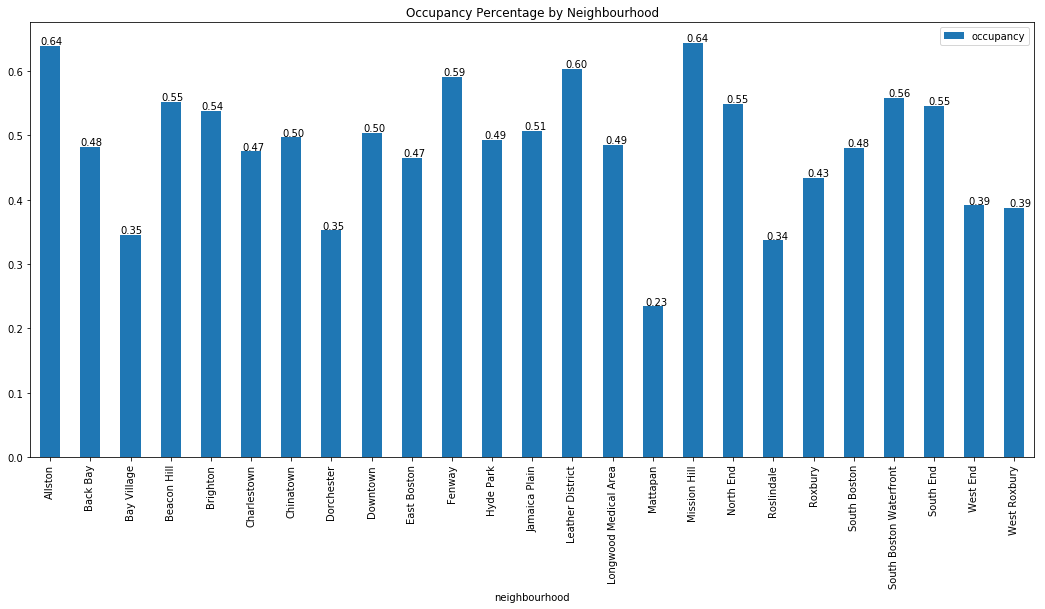

In [75]:
plt_data = dfc_listings[['neighbourhood', 'occupancy']].groupby('neighbourhood').mean()

ax = plt_data.plot(kind="bar", title="Occupancy Percentage by Neighbourhood", label="Neighbourhood", figsize=(18,8));

for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    

- Alston, Mission Hill and Leather Hill have high average occupancy
- Mattapan and Roslindale have least occupancy rates

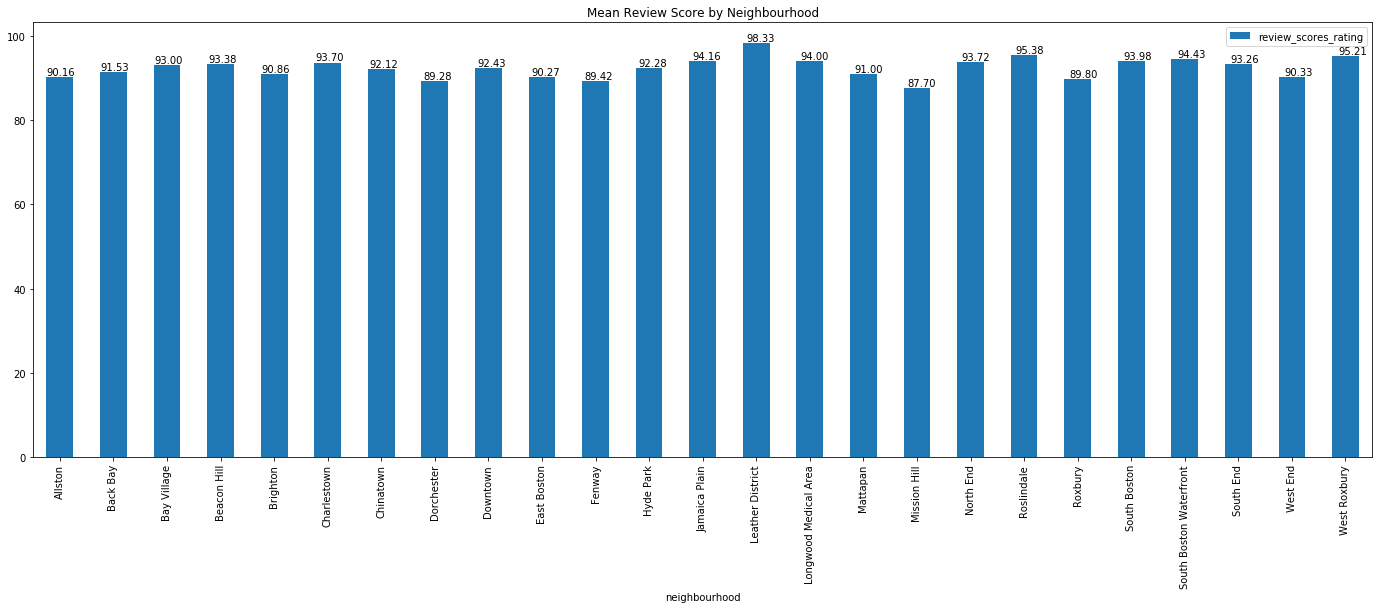

In [76]:
plt_data = dfc_listings[['neighbourhood', 'review_scores_rating']].groupby('neighbourhood').mean()

#plt_data.review_scores_rating = plt_data.review_scores_rating.apply(lambda c : c - 80)
ax = plt_data.plot(kind="bar", title="Mean Review Score by Neighbourhood", label="Neighbourhood", figsize=(24,8));

for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    

- Average customer ratings vary in a range of 88 - 98
- Mission Hill has lowest averaage customer review
- Leather District has highest customer review ratings

### Peak and lean seasons

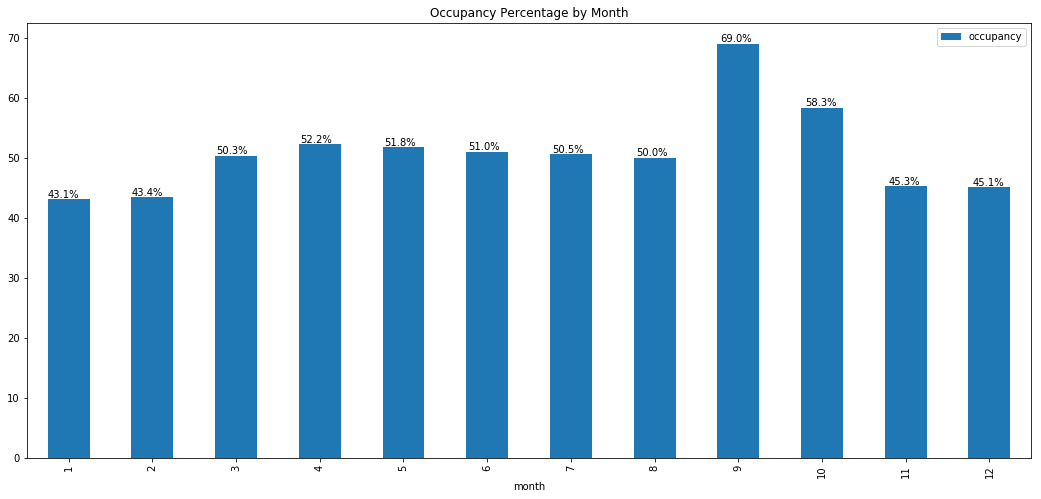

In [77]:
df = df_occupancy[['month', 'occupancy']].groupby(['month']).mean()

ax = df.plot(kind="bar", title="Occupancy Percentage by Month", figsize=(18,8));

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- September and October show high occupancy 
- January and February have low occupancy
- The occupancy is around 50% for most of the remaining period.

** These observations may not be conclusive as it looks at data only for one year**

## Does number of listings in neighbourhood affect the occupancy?

Let us see if there are some neighbourhoods showing low occupancy rates coupled with high number of listings.


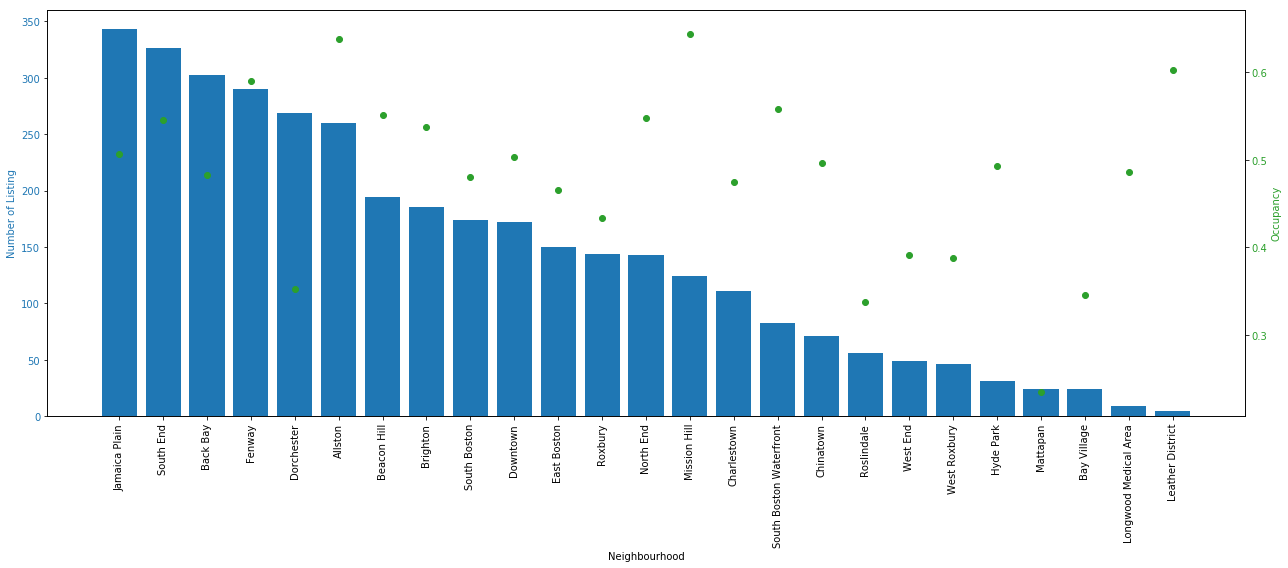

In [78]:
d1 = pd.DataFrame(dfc_listings.neighbourhood.value_counts()).rename(columns={'neighbourhood':'listing_count'})
d2 = dfc_listings[['neighbourhood', 'occupancy']].groupby('neighbourhood').mean()
data1 = pd.merge(d1, d2, left_index=True, right_index=True)

fig, ax1 = plt.subplots(figsize=(18,8))

color = 'tab:blue'
ax1.set_xlabel('Neighbourhood')
ax1.set_ylabel('Number of Listing', color=color)
ax1.bar(data1.index, data1.listing_count, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x',rotation=90)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Occupancy', color=color)  # we already handled the x-label with ax1
ax2.scatter(data1.index, data1.occupancy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

- Leather District has very less number of listings with high occupancy
- Highest number of listings are in Jamaica Plain and South End. However, these neighbourhoods still have higher occupancy rates compared to many other neighbourhoods.
- Mattapan offers one of the least number of listings and is still having less occupancy.

In summary, the plot is all over the place and there is clearly no sign of over crowding of listings in any neighbourhood.
- 

### How are listing features correlated?

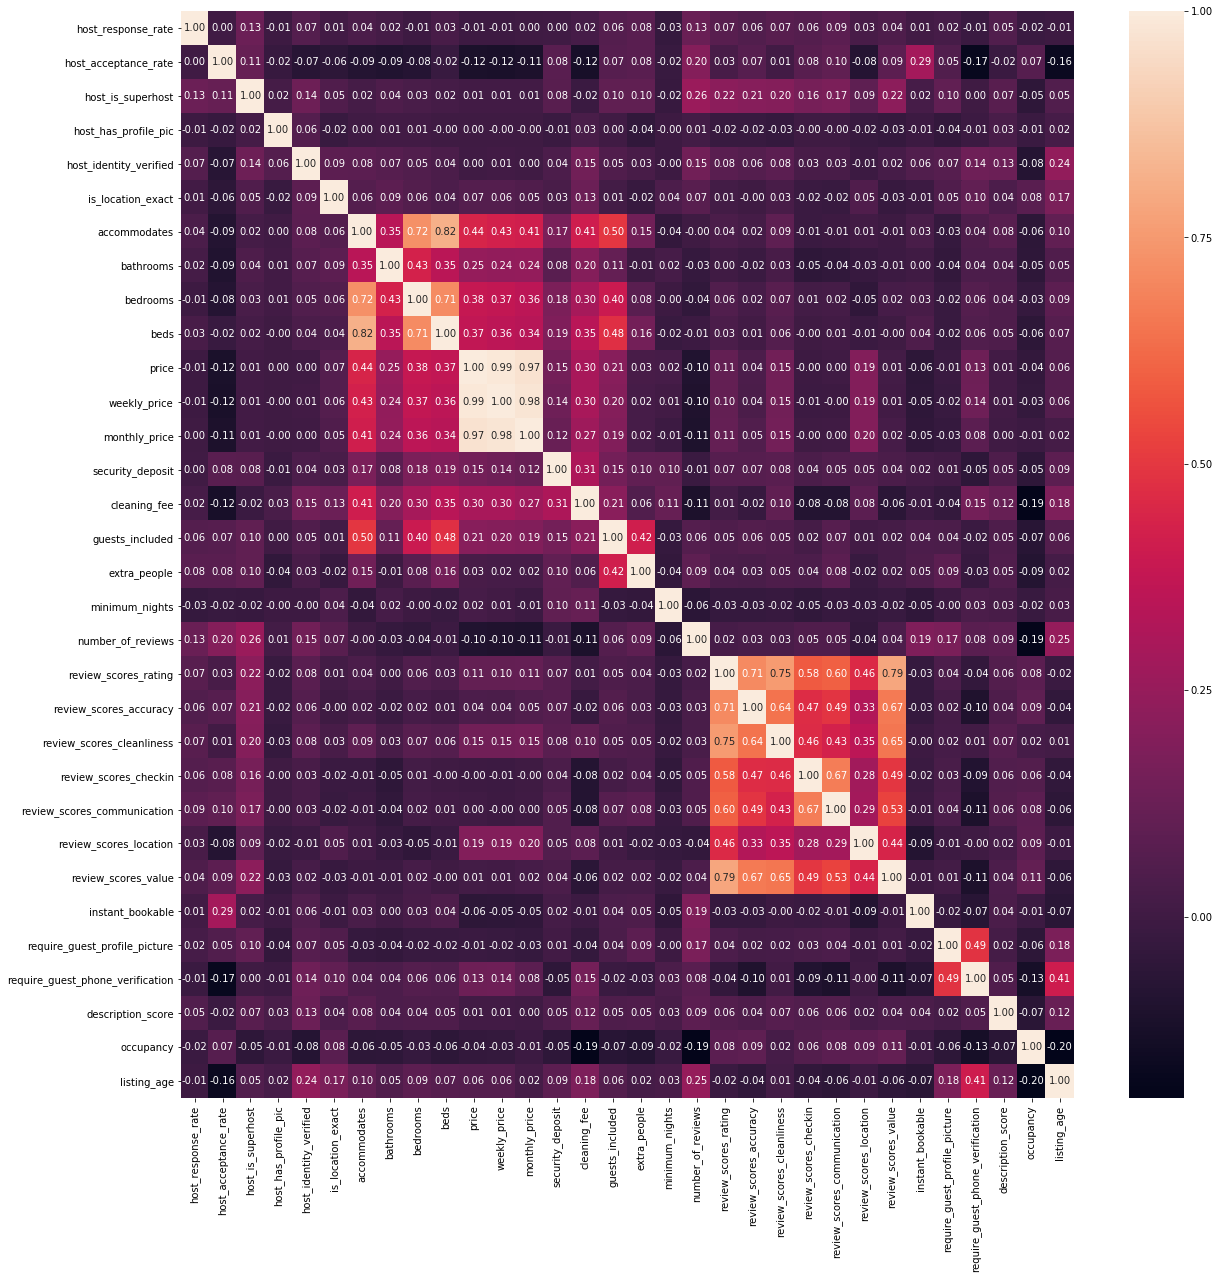

In [79]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(dfc_listings.drop('id', axis=1).corr(), ax=ax, annot=True, fmt=".2f");

- There are two clear boxes seen. 
    - Number of Guests, Bathrooms, Bedrooms, Beds and Price seem to have close correlation which is obvious
    - Similarly various customer review ratings show high correlation
- Occupancy
    - Shows positive relation with review scores
    - Old listings seem to have inverse relation with occupancy i.e. people prefer newly listed property
    - Cleaning Fee and Requirement for Guest Phone Verification also seems to bring down occupancy
- Other observations
    - More old listings mandate the phone verification for guests compared to newer listings
    - Newer listings appear more open and have less stringent requirements for verification

### Features affecting the occupancy and customer ratings

In [80]:
# Top 10 features affecting occupancy
occupancy_results[3].head(10)

,est_int,coefs,abs_coefs
71,property_type_Villa,8.410056e+11,8.410056e+11
64,property_type_Dorm,8.410056e+11,8.410056e+11
68,property_type_Loft,8.410056e+11,8.410056e+11
63,property_type_Condominium,8.410056e+11,8.410056e+11
70,property_type_Townhouse,8.410056e+11,8.410056e+11
60,property_type_Apartment,8.410056e+11,8.410056e+11
67,property_type_House,8.410056e+11,8.410056e+11
66,property_type_Guesthouse,8.410056e+11,8.410056e+11
62,property_type_Boat,8.410056e+11,8.410056e+11
61,property_type_Bed & Breakfast,8.410056e+11,8.410056e+11


In [81]:
# Top 10 features affecting occupancy
reviewscores_results[3].head(10)

,est_int,coefs,abs_coefs
32,host_response_time_within a day,4.800402e+12,4.800402e+12
31,host_response_time_a few days or more,4.800402e+12,4.800402e+12
33,host_response_time_within a few hours,4.800402e+12,4.800402e+12
34,host_response_time_within an hour,4.800402e+12,4.800402e+12
64,property_type_Dorm,-2.098155e+12,2.098155e+12
67,property_type_House,-2.098155e+12,2.098155e+12
63,property_type_Condominium,-2.098155e+12,2.098155e+12
60,property_type_Apartment,-2.098155e+12,2.098155e+12
71,property_type_Villa,-2.098155e+12,2.098155e+12
70,property_type_Townhouse,-2.098155e+12,2.098155e+12


# Conclusion

- There are few neighbourhoods that show higher occupancy compared to others. However, there are no standouts by great margin
- September and October appear to be peak seasons. However, any conclusion on this needs analysis of data over years.
- Poor correlation between number of properties in a neighbourhoood and occupancy rate. **No conclusive evidence to suggest over supply of properties in any neighbourhood**
- Prominant features deciding occupancy
  - **Property type seems to be most important feature that renters look for with special preference to Villa and appartments**
  - **This is followed by bed type with general dislike for properties with air-beds and couches**
- Prominant features deciding review ratings
  - **Host Response Time showed up as most important feature deciding the review ratings. Possibly due to the first impression effect**
  - **This was followed by property type and cancellation policy**